# Interpolate `MeshArray` To Arbitrary Location

Each `MeshArray` contains elementary arrays that collectively form a global domain grid. Here we interpolate from the global grid to a set of arbitary locations. This is commonly done e.g. to compare climate models to sparse field observations.

In brief, the program finds a grid point quadrilateral (4 grid points) that encloses each chosen location. Computation is chuncked in subdomains (tiles) t o allow for parallelism. It outputs interpolation coefficients -- reusing those is easy and fast.

## Initialize Framework

1. import `MeshArrays` and plotting tools
2. choose e.g. a standard `MITgcm` grid
3. download the grid if needed


In [1]:
using MeshArrays, MITgcmTools, Plots

pth="../inputs/GRID_LLC90/"
γ=GridSpec("LatLonCap",pth)
Γ=GridLoad(γ)

http="https://github.com/gaelforget/GRID_LLC90"
!isdir(pth) ? run(`git clone $http $pth`) : nothing;

┌ Info: Precompiling MeshArrays [cb8c808f-1acf-59a3-9d2b-6e38d009f683]
└ @ Base loading.jl:1273
┌ Info: Precompiling MITgcmTools [62725fbc-3a66-4df3-9000-e33e85b3a198]
└ @ Base loading.jl:1273


## Interpolation Code

- get map of tile numbers (`MeshArray`)
- find nearest neighbor (`MeshArray` & `set`)
- exchange and start loop (`tile` & `subset`)
    - local stereographic projection
    - define array of quadrilaterals
    - find enclosing quadrilaterals
    - compute interpolation coefficients

### Define Subdomain Tiles

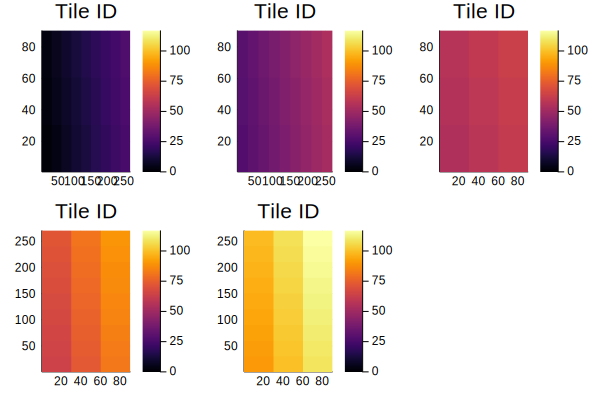

In [2]:
ni=30; nj=30;
τ=Tiles(γ,ni,nj)

tiles=MeshArray(γ,Int);
[tiles[τ[i]["face"]][τ[i]["i"],τ[i]["j"]].=i for i in 1:length(τ)];   

using Plots
include(joinpath(dirname(pathof(MeshArrays)),"../examples/Plots.jl"))
heatmap(tiles,title="Tile ID",clims=(0,length(τ)))

### find nearest neighbor

In [3]:
using NearestNeighbors

XC=collect(0.1:0.5:2.1); YC=collect(0.1:0.5:2.1);
#XC=0.1; YC=0.1;

XC_a=write(Γ["XC"])
YC_a=write(Γ["YC"])
tiles_a=write(tiles)
kk=findall(isfinite.(XC_a))

x=sin.(pi/2 .-YC_a[kk]*pi/180).*cos.(XC_a[kk]*pi/180);
y=sin.(pi/2 .-YC_a[kk]*pi/180).*sin.(XC_a[kk]*pi/180);
z=cos.(pi/2 .-YC_a[kk]*pi/180);

xx=sin.(pi/2 .-YC*pi/180).*cos.(XC*pi/180);
yy=sin.(pi/2 .-YC*pi/180).*sin.(XC*pi/180);
zz=cos.(pi/2 .-YC*pi/180);

kdtree = KDTree([x y z]')
idxs, dists = knn(kdtree, [xx yy zz]', 4, true)

ik=[idxs[i][1] for i in 1:length(XC)]
[XC_a[ik] YC_a[ik] tiles_a[ik]]

5×3 Array{Float64,2}:
 0.5  0.199365  17.0
 0.5  0.602104  17.0
 1.5  1.01667   17.0
 1.5  1.4512    17.0
 2.5  1.91446   17.0

### Prepare Arrays For Interpolation

In [4]:
list_tile=[tiles_a[ik]];
ii=1; iiTile=Int(list_tile[ii][1])
#println(iiTile)
#iiTile=17

XC_tmp=Tiles(τ,exchange(Γ["XC"]))[iiTile]
YC_tmp=Tiles(τ,exchange(Γ["YC"]))[iiTile]

iiFace=τ[iiTile]["face"]
ii0=minimum(τ[iiTile]["i"])+Int(ni/2)
jj0=minimum(τ[iiTile]["j"])+Int(nj/2)
XC0=Γ["XG"].f[iiFace][ii0,jj0]
YC0=Γ["YG"].f[iiFace][ii0,jj0]

#to match gcmfaces test case (`interp=gcmfaces_interp_coeffs(0.1,0.1);`) set:
#  iiTile=17; XC0=6.5000; YC0=-0.1994
#or equivalently:
#  ii0=Int(floor((iiMin+iiMax)/2)); jj0=Int(floor((jjMin+jjMax)/2));
#  XC0=Γ["XC"].f[iiFace][ii0,jj0]; YC0=Γ["YC"].f[iiFace][ii0,jj0];

### Example Setup (Grid Space)

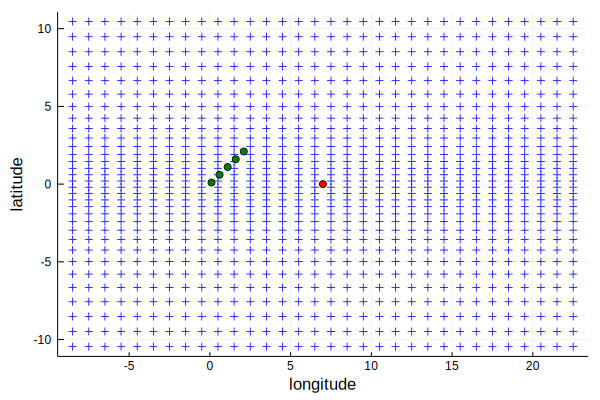

In [5]:
scatter(XC_tmp,YC_tmp,marker=:+,c=:blue,leg=false,xlabel="longitude",ylabel="latitude")
scatter!([XC0],[YC0],c=:red)
scatter!([XC],[YC],c=:green)

### Local Stereographic Projection

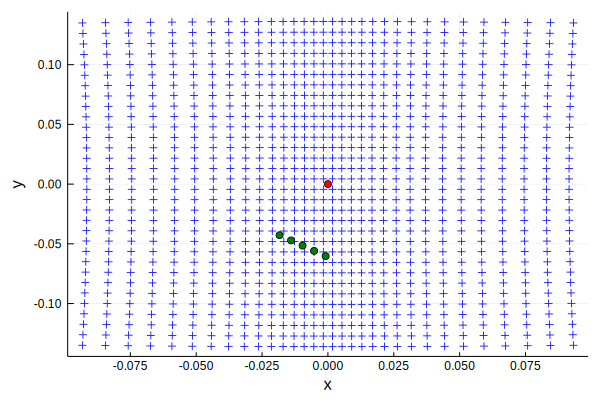

In [6]:
(xx,yy)=StereographicProjection(XC0,YC0,XC_tmp,YC_tmp)
(prof_x,prof_y)=StereographicProjection(XC0,YC0,XC,YC)
~isa(prof_x,Array) ? prof_x=[prof_x] : nothing
~isa(prof_y,Array) ? prof_y=[prof_y] : nothing

scatter(xx,yy,marker=:+,c=:blue,leg=false,xlabel="x",ylabel="y")
scatter!([0.],[0.],c=:red); scatter!(prof_x,prof_y,c=:green)

### Define Quadrilaterals

In [7]:
x_quad=Array{Float64,2}(undef,(ni+1)*(nj+1),4)
y_quad=Array{Float64,2}(undef,(ni+1)*(nj+1),4)
i_quad=Array{Int64,2}(undef,(ni+1)*(nj+1),4)
j_quad=Array{Int64,2}(undef,(ni+1)*(nj+1),4)

didj=[[0 0];[1 0];[1 1];[0 1]]
for pp=1:4
    di=didj[pp,1]
    dj=didj[pp,2]

    #note the shift in indices due to exchange above
    tmp=xx[1+di:ni+1+di,1+dj:nj+1+dj]
    x_quad[:,pp]=vec(tmp)
    tmp=yy[1+di:ni+1+di,1+dj:nj+1+dj]
    y_quad[:,pp]=vec(tmp)

    tmp=collect(0+di:ni+di)*ones(1,nj+1)
    i_quad[:,pp]=vec(tmp)
    tmp=ones(ni+1,1)*transpose(collect(0+dj:nj+dj));
    j_quad[:,pp]=vec(tmp)
end

### Identify Quadrilaterals

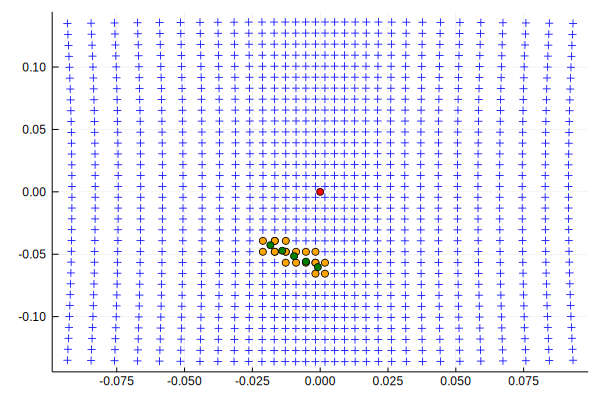

In [8]:
angsum=PolygonAngle(x_quad,y_quad,prof_x,prof_y)
ii=findall(angsum.>180.)
ii=[ii[j].I[1] for j in 1:length(ii)]

scatter(xx,yy,marker=:+,c=:blue,leg=false)
scatter!([0.],[0.],c=:red)
scatter!(x_quad[ii,:],y_quad[ii,:],c=:orange)
scatter!(prof_x,prof_y,c=:green)

### Interpolation Coefficients

In [9]:
px=x_quad[ii[1],:]'
py=y_quad[ii[1],:]'
ox=[prof_x[1]]
oy=[prof_y[1]]

ow=QuadCoeffs(px,py,ox,oy)

Dict("face" => iiFace, "tile" => iiTile, "i" => i_quad[ii,:]', "j" => j_quad[ii,:]', "w" => dropdims(ow,dims=2))

Dict{String,Any} with 5 entries:
  "w"    => [0.0995274 0.149361 0.450751 0.300361]
  "face" => 1
  "j"    => [15 16 … 19 20; 15 16 … 19 20; 16 17 … 20 21; 16 17 … 20 21]
  "tile" => 17
  "i"    => [8 9 … 10 10; 9 10 … 11 11; 9 10 … 11 11; 8 9 … 10 10]

In [10]:
px=x_quad[ii,:]
py=y_quad[ii,:]
ox=prof_x
oy=prof_y

ow=QuadCoeffs(px,py,ox,oy)

Dict("face" => iiFace, "tile" => iiTile, "i" => i_quad[ii,:], "j" => j_quad[ii,:], "w" => dropdims(ow,dims=2))

Dict{String,Any} with 5 entries:
  "w"    => [0.0995274 0.149361 0.450751 0.300361; 0.00471157 0.00052375 0.0995…
  "face" => 1
  "j"    => [15 15 16 16; 16 16 17 17; … ; 19 19 20 20; 20 20 21 21]
  "tile" => 17
  "i"    => [8 9 9 8; 9 10 10 9; … ; 10 11 11 10; 10 11 11 10]

### Verify Results

Interpolate longitude and latitude from coefficients and compare with initial `XC,YC`.

_Note that `XC_tmp,YC_tmp` each are `tile+halo`, which explains the `+1` index shift_

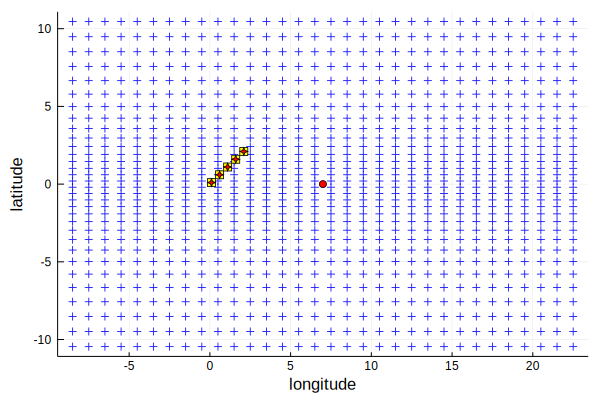

In [11]:
XC_interp=similar(XC)
YC_interp=similar(YC)

for j=1:length(ox)
w=vec(ow[j,:,:])
x=[XC_tmp[i_quad[ii[j],i]+1,j_quad[ii[j],i]+1] for i=1:4]
y=[YC_tmp[i_quad[ii[j],i]+1,j_quad[ii[j],i]+1] for i=1:4]
#println([sum(w.*x) sum(w.*y)])
XC_interp[j]=sum(w.*x)
YC_interp[j]=sum(w.*y)
end

scatter(XC_tmp,YC_tmp,marker=:+,c=:blue,leg=false,xlabel="longitude",ylabel="latitude")
scatter!([XC0],[YC0],c=:red)
scatter!(XC_interp,YC_interp,c=:yellow,marker=:square)
scatter!(XC,YC,c=:red,marker=:star4)